In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import *
import re
from matplotlib import pyplot as plt
import sqlite3

<h3>SQLite Handling functions</h3>
<p>Use Pandas to import dataframe into SQLlite</p>

In [7]:
DB = "hockey_dataMVP.db"

#SQL Handle functions
def run_query(q):
    with sqlite3.connect(DB) as conn:
        x = pd.read_sql(q,conn)
    return x
   
#send command
def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
#show tables
def show_tables():
    r = """
    Select name,type
    FROM sqlite_master
    WHERE type in ("table","view");
        """
    return run_query(r)

In [32]:
not_injured = run_query("""SELECT COUNT(pl.player_id) as injuries From player_log pl WHERE pl.injured =0""")['injuries'].values
injured = run_query("""SELECT COUNT(pl.player_id) as injuries From player_log pl WHERE pl.injured =1""")['injuries'].values
print('There are %d injuries in %entries' % (injured,injured+not_injured))

There are 11529 injuries in 1.133894e+06ntries


In [34]:
run_query("""PRAGMA table_info(player_log);""")

,cid,name,type,notnull,dflt_value,pk
0,0,gamelog_id,TEXT,0,None,1
1,1,player_id,TEXT,0,None,0
2,2,date_game,TEXT,0,None,0
3,3,age,REAL,0,None,0
4,4,min_season,REAL,0,None,0
5,5,min_3w,REAL,0,None,0
6,6,days_to_next_g,INTEGER,0,None,0
7,7,timec,REAL,0,None,0
8,8,venuec,REAL,0,None,0
9,9,injured,INT,0,None,0


In [92]:
no_injury = run_query("""WITH 
            /*Add year*/
            add_year AS (SELECT pl.*, CAST(SUBSTR(pl.date_game,1,4) AS INT) as YEAR 
                          FROM player_log pl),
            /*REMOVE Record Before 1997 as Time on Ice wasn't recorded*/
            post_1997 AS (SELECT ady.*
                          FROM add_year ady
                          WHERE ady.YEAR > 1997)
            /*SELECT 20000 entries with no injuries and join to those with injuries*/
            SELECT pl.position,pl.weight_kg,po.age,po.min_season,po.min_3w,po.days_to_next_g,po.timec,po.venuec,po.injured
            FROM post_1997 po
            LEFT JOIN player_list pl ON pl.unique_id=po.player_id
            WHERE injured = 0 AND days_to_next_g < 20
            ORDER BY RANDOM()
            LIMIT 20000
            """)
injury = run_query("""WITH 
            /*Add year*/
            add_year AS (SELECT pl.*, CAST(SUBSTR(pl.date_game,1,4) AS INT) as YEAR 
                          FROM player_log pl),
            /*REMOVE Record Before 1997 as Time on Ice wasn't recorded*/
            post_1997 AS (SELECT ady.*
                          FROM add_year ady
                          WHERE ady.YEAR > 1997)
            /*SELECT 20000 entries with no injuries and join to those with injuries*/
            SELECT pl.position,pl.weight_kg,po.age,po.min_season,po.min_3w,po.days_to_next_g,po.timec,po.venuec,po.injured
            FROM post_1997 po
            LEFT JOIN player_list pl ON pl.unique_id=po.player_id
            WHERE injured = 1 AND days_to_next_g < 20
            ORDER BY RANDOM()
            LIMIT 10000
            """)

In [177]:
dataset = injury.append(no_injury).sample(frac=1) #add together and randomize
traindataset = dataset.iloc[:24000]
testdataset = dataset.iloc[24000:]

In [178]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_validate as CV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [179]:
enc = OneHotEncoder()
trposhot = enc.fit_transform(np.array(traindataset['position']).reshape(-1,1))
teposhot = enc.fit_transform(np.array(testdataset['position']).reshape(-1,1))

In [180]:
#create a pipeline to scale the variables for better weighting.
num_pipline = Pipeline([('std_scaler',StandardScaler())])
#scale data
trainsc = num_pipline.fit_transform(np.array(traindataset.iloc[:,1:-1]))
testsc = num_pipline.fit_transform(np.array(testdataset.iloc[:,1:-1]))

In [181]:
#put data together
train = np.concatenate((trposhot.toarray(),trainsc),axis=1)
trainv = np.array(traindataset['injured'])
test =  np.concatenate((teposhot.toarray(),testsc),axis=1)
testv = np.array(testdataset['injured'])

In [182]:
forest_class = RandomForestClassifier()
forest_class.fit(train,trainv)

RandomForestClassifier()

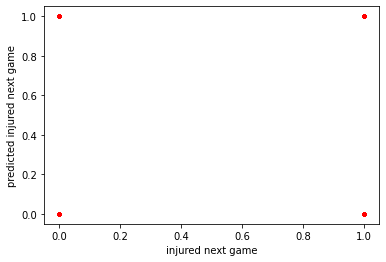

In [183]:
testp =forest_class.predict(test)
plt.plot(testv,testp,'r.')
plt.xlabel('injured next game')
plt.ylabel('predicted injured next game')
plt.show()

In [184]:
testv.sum()

2027

In [185]:
testp.sum()

472

In [186]:
test.shape

(6000, 10)